# ERA5 Climate Gridded Data

* **Products used:** 
[ERA5](https://registry.opendata.aws/ecmwf-era5/)

This dataset is external to the Digital Earth Africa platform.

## Background

This notebook demonstrates how to access and use the European Centre for Medium Range Weather Forecasts (ECMWF) global climate reanalysis product called, ERA5, from the [AWS Public Dataset Program](https://registry.opendata.aws/ecmwf-era5/). 

This 5th generation operational service utilizes the best available observation data from satellites and in-situ stations, which are assimilated and processed using ECMWF's Integrated Forecast System. The dataset provides essential atmospheric meteorological parameters such as air temperature, pressure and wind at different altitudes, along with surface parameters like rainfall, and sea parameters like sea-surface temperature and wave height. Spatial resolution is 0.25 degrees (latitude and longitude) which equates to about 31 km. Data is available from 1979 to present and is updated operationally.

For offical information on this dataset, see [ERA5 data documentation from ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).

The ERA5 dataset in AWS is nominally updated monthly.

## Description

We recommend use of ERA5 data in Zarr format which allows cloud native access without the need to download data.

15 surface or single level variables are accessible using the `load_era5()` wrapper function.

| Catagory | Variable | Name for query |
|:--- |:--- |:--- |
| Precipitation | Total precipitation | precipitation_amount_1hour_Accumulation 
| Wind | 10 metre U wind component | eastward_wind_at_10_metres 
| | 10 metre V wind component | northward_wind_at_10_metres
| | 100 metre U wind component | eastward_wind_at_100_metres
| | 100 metre V wind component | northward_wind_at_100_metres
| Temperature | 2 metre temperature | air_temperature_at_2_metres
| | 2 metres maximum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Maximum
| | 2 metres minimum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Minimum
| | 2 metre dew point temperature | dew_point_temperature_at_2_metres
| | Sea surface temperature | sea_surface_temperature
| Air Pressure | Mean sea level pressure | air_pressure_at_mean_sea_level
| | Surface pressure | surface_air_pressure
| Snow | Snow density | snow_density
| | Snow depth | lwe_thickness_of_surface_snow_amount
| Solar radiation | Surface solar radiation downwards | integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation


The ERA5 dataset is also available in netcdf format, as described [here](https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md). 
The following sea surface variables are only available in netcdf format, and can be downloaded using the `load_era5_netcdf()` function.
Use of netcdf data will not be elaborated in this notebook.

| Catagory | Variable | Name for query |
|:--- |:--- |:--- |
| Wave | Mean wave period | sea_surface_wave_mean_period
| | Mean direction of waves | sea_surface_wave_from_direction
| | Significant height of combined wind waves and swell | significant_height_of_wind_and_swell_waves


This notebook covers examples for accessing and working with the following variables:
1. Daily total precipitation
2. Daily minimum and maximum air temperature at 2 metres height
3. Hourly wind speed at 10 metres height
4. Monthly maximum air temperature at 2 metres height for the continent

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import datacube
import s3fs

from deafrica_tools.load_era5 import load_era5

### List available measurements in Zarr format

In [2]:
# set AWS region to access ERA5 data
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name':'us-east-1'})

In [3]:
# data is structred as era5-pds/zarr/<year>/<month>/data/
# available measurements should be consistent across time, so use 2021/04 to check
# to confirm for a different time period, replace the year and month values

s3.ls('era5-pds/zarr/2021/04/data/')

['era5-pds/zarr/2021/04/data/air_pressure_at_mean_sea_level.zarr',
 'era5-pds/zarr/2021/04/data/air_temperature_at_2_metres.zarr',
 'era5-pds/zarr/2021/04/data/air_temperature_at_2_metres_1hour_Maximum.zarr',
 'era5-pds/zarr/2021/04/data/air_temperature_at_2_metres_1hour_Minimum.zarr',
 'era5-pds/zarr/2021/04/data/dew_point_temperature_at_2_metres.zarr',
 'era5-pds/zarr/2021/04/data/eastward_wind_at_100_metres.zarr',
 'era5-pds/zarr/2021/04/data/eastward_wind_at_10_metres.zarr',
 'era5-pds/zarr/2021/04/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.zarr',
 'era5-pds/zarr/2021/04/data/lwe_thickness_of_surface_snow_amount.zarr',
 'era5-pds/zarr/2021/04/data/northward_wind_at_100_metres.zarr',
 'era5-pds/zarr/2021/04/data/northward_wind_at_10_metres.zarr',
 'era5-pds/zarr/2021/04/data/precipitation_amount_1hour_Accumulation.zarr',
 'era5-pds/zarr/2021/04/data/sea_surface_temperature.zarr',
 'era5-pds/zarr/2021/04/data/snow_density.zarr',
 'er

### Analysis parameters

Define location and time period of interest.
For an initial test, use a time period of no more than a few months to limit data access.

* `lat` & `lon`: The latitude and longitude range for the area of interest.
* `time`: The time range you wish to extract data for. Times can be provided as year, month or date strings or datetime objects.


In [4]:
# Lake Turkana Wind Power Station, Kenya
lat = (2.45, 2.55)
lon = (36.75, 36.85)

# Define the time window
time = '2021-01', '2021-03'

## Daily total precipitation

Total precipitation is the accumulated liquid and frozen water, comprising rain and snow, that falls to the Earth's surface.
It does not include fog, dew or the precipitation that evaporates in the atmosphere before it lands on the surface of the Earth. 
The units of this parameter are depth in metres of water equivalent. It is the depth the water would have if it were spread evenly over the grid box. 
Care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box.

In this example, total precipitation is aggregated at daily intervals.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to np.sum to calculate total precipitation.
* `resample`: temporal resampling frequency, '1D' (as default) for daily aggregation.

Note that the output spatial grid is snapped to the nearest input grid points.

In [5]:
var = 'precipitation_amount_1hour_Accumulation'

precip = load_era5(var, lat, lon, time, reduce_func=np.sum, resample='1D').compute()

In [6]:
# convert to Millimeters (mm), keeping other attributes
attrs = precip[var].attrs
attrs['units']='mm'
precip = precip*1000
precip[var].attrs = attrs

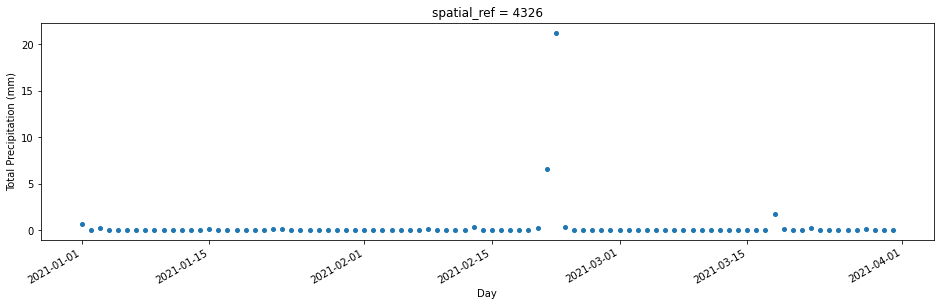

In [7]:
# plot daily total precipitation for this area
precip[var].sum(['lat','lon']).plot(figsize = (16,4), marker='o', markersize=4, linewidth=0);
plt.xlabel('Day');
plt.ylabel('%s (%s)'%('Total Precipitation', precip[var].attrs['units']));

## Daily minimum and maximum air temperature at 2 metres height

Air temperature estimates are provided in kelvin (K) and can be converted to degrees Celsius (°C) by subtracting 273.15.

In this example, highest and lowerest daily temperatures are extracted.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to np.max and np.min to calculate maximum and minimum temperature.
* `resample`: temporal resampling frequency, '1D' (as default) for daily aggregation.

Note that the output spatial grid is snapped to the nearest input grid points.

In [8]:
temp_var = 'air_temperature_at_2_metres'

temp_max = load_era5(temp_var, lat, lon, time, reduce_func=np.max, resample='1D').compute()

temp_min = load_era5(temp_var, lat, lon, time, reduce_func=np.min, resample='1D').compute()


In [9]:
# convert to Celsius, keeping other attributes
attrs = temp_max.attrs
attrs['units']='C'
temp_max, temp_min = temp_max-273.15, temp_min-273.15
temp_max[temp_var].attrs = attrs
temp_min[temp_var].attrs = attrs

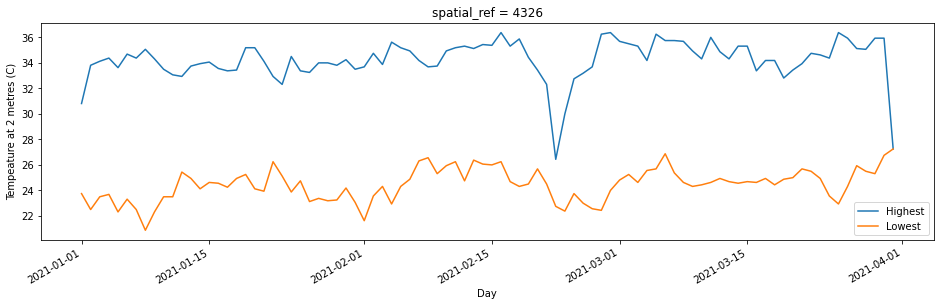

In [10]:
# plot mean temperatures for this area
temp_max[temp_var].mean(['lat','lon']).plot(figsize = (16,4), label='Highest');
temp_min[temp_var].mean(['lat','lon']).plot(label='Lowest');
plt.legend();
plt.xlabel('Day');
plt.ylabel('%s (%s)'%('Tempeature at 2 metres', temp_max[temp_var].attrs['units']));

## Maximum hourly wind speed at 10 metres height

Wind causes changes in surface characteristics of some land cover types, e.g. surface roughness of water. 
Increased surface roughness leads to an increase in measured radar backscatter.
Although typically stronger than wind at the surface, wind at 10 metres height may be used to flag windy conditions.

In ERA5, horizontal wind estimate is provided in metres per second and is represented by an eastward component and a northward component. 
A negative sign indicates air moving in the opposite direction, e.g. towards the west for the eastward component.
The two components can be combined to give the speed and direction of the horizontal wind.

Wind speed is highly variable throughout a day, so sampling is kept at hourly.

Optional parameters used to load data:

* `resample`: temporal resampling frequency, '1h' so that output data is at same frequency as input.

Note that the output spatial grid is snapped to the nearest input grid points.

In [11]:
east = "eastward_wind_at_10_metres"
north = "northward_wind_at_10_metres"

wind_east = load_era5(east, lat, lon, time, resample='1h').compute()

wind_north = load_era5(north, lat, lon, time, resample='1h').compute()

### Combine the two wind components to get wind speed

Magnitude of the wind speed is calculated from U and V components as $sqrt(U^2 + V^2)$.

In [12]:
wind = (wind_east[east]**2 + wind_north[north]**2)**0.5
wind.attrs['units'] = wind_east[east].attrs['units']

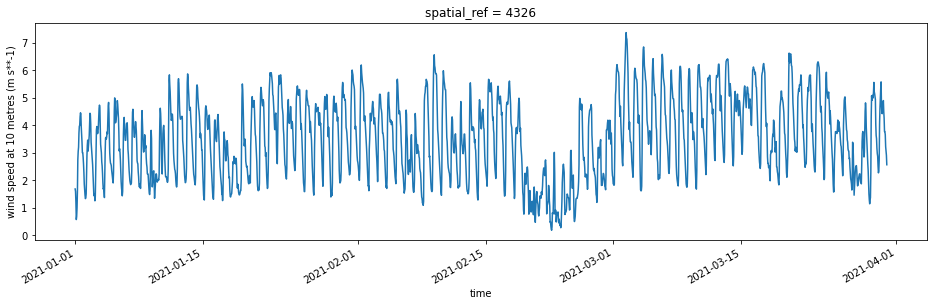

In [13]:
# plot mean wind speed for this area
wind.mean(['lat','lon']).plot(figsize = (16,4));
plt.ylabel('%s (%s)'%('wind speed at 10 metres', wind.attrs['units']));

## Monthly maximum air temperature at 2 metres height

In this example, maximum air temperature at 2 metres height is retrieved monthly for the African continent.

Latitude and Longitude ranges are set to cover the continent.
Time range is set from Janurary to March 2021.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to np.max to calculate maximum temperature.


In [14]:
temp_var = 'air_temperature_at_2_metres'

temp_max_month = load_era5(temp_var, (-40, 40), (-20, 60), ('2021-01', '2021-03'), reduce_func=np.max, resample='1M').compute()

# convert to Celsius, keeping other attributes
attrs = temp_max_month.attrs
attrs['units']='C'
temp_max_month = temp_max_month-273.15
temp_max_month[temp_var].attrs = attrs

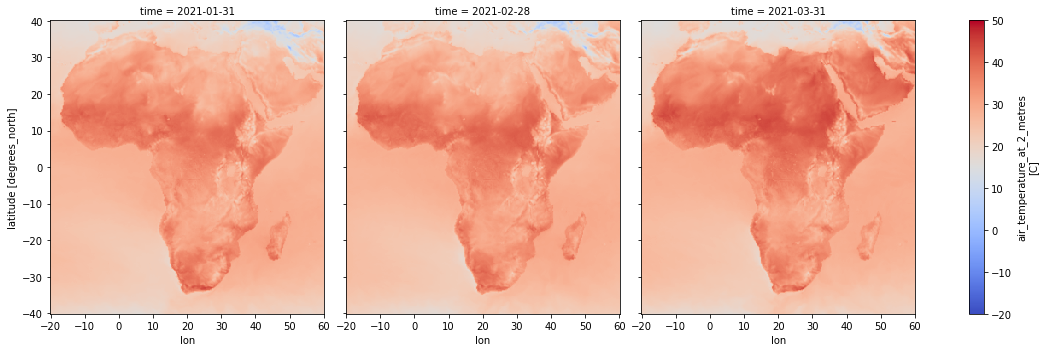

In [15]:
# plot for each month
temp_max_month[temp_var].plot(col='time', col_wrap=3, vmin=-20, vmax=50, cmap = 'coolwarm', figsize=(16, 5));

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-29'